## Overview

We are a data analytics consulting company named Quisitive looking to provide predictive and actionable insights regarding the forward trajectory and absolute level of the Federal Funds Interest Rate using the power of big data. We hope to create a complex time series model that incorporates an Auto Regression and Moving Average lag term among with a seasonality and differencing term. We hope to be able to swiftly and effectively achieve forecasted Federal Funds Interest Rate estimates closer to reality than our baseline random walk model. 

## Business Problem

The optimization and prediction of interest rates in the economy has long been a hot topic of study within the financial community. Whether it's credit card rates, mortgages rates, US Treasury rates, or Federal Funds Rate (bank to bank overnight lending rate) economists and analysts alike have long yearned for a tool that can accurately and rapidly forecast interest rates into the future. Here, we are focused on the Federal Funds Rate, a rate that is determined by the Federal Reserve and is the foundation of credit markets. Given that the Federal Funds Rate is the shortest term loan, all other longer term interest rates are priced around this metric. We hope to lend our predictive capabilities to key financial institutions and emerging FinTech companies and allow them to accurately price both consumer and interest rate risk. We strive to help these institutions minimize bad debt and reduce credit losses.

## Data Understanding

We are sourcing the data set for this project from the St. Louis Fed FRED Economic Data website, which can be found at Federal_Funds_Rate.csv in the data folder in the Github Repository. We reviewed 610 monthly Fed Funds rate values from July 1, 1971 to April 1, 2022. Limitations of our model includes a narrow timeframe data set, lack of independent variables, and our data points are not mutually independent (time series model problem, each data point is dependent on the value before it).

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pylab as plt
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import statsmodels.api as sm

In [8]:
#Bringing in our target variable data set 
df_FF = pd.read_csv("../Data/Federal_Funds_Rate.csv")
df_FF['DATE'] = pd.to_datetime(df_FF.DATE)
df_FF.set_index('DATE', inplace=True)
df_FF = df_FF['1971-07-01':'2022-04-01']
df_FF

,FEDFUNDS
DATE,
1971-07-01,5.31
1971-08-01,5.57
1971-09-01,5.55
1971-10-01,5.20
1971-11-01,4.91
...,...
2021-12-01,0.08
2022-01-01,0.08
2022-02-01,0.08


##  Visualizations

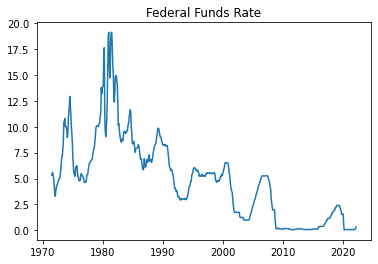

In [9]:
#Visualizing the target variable
fig, ax = plt.subplots()
ax.plot(df_FF.FEDFUNDS)
ax.set_title("Federal Funds Rate");

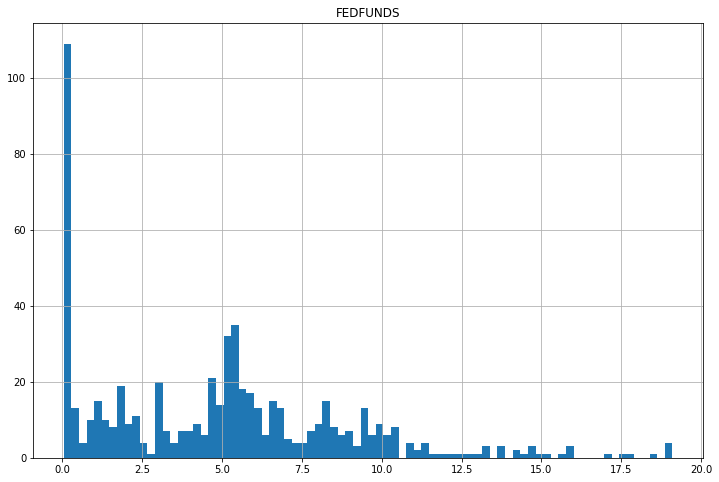

In [10]:
#Another histogram visualization, showing the frequency of each level of interest rates 
df_FF.hist(figsize = (12,8), bins=80);

In [11]:
df_FF

,FEDFUNDS
DATE,
1971-07-01,5.31
1971-08-01,5.57
1971-09-01,5.55
1971-10-01,5.20
1971-11-01,4.91
...,...
2021-12-01,0.08
2022-01-01,0.08
2022-02-01,0.08


In [12]:
### need to full years to properly graph annual plot
df_FF_fullyears = df_FF.loc['1971-01-01':'2021-12-01']
df_FF_fullyears

,FEDFUNDS
DATE,
1971-07-01,5.31
1971-08-01,5.57
1971-09-01,5.55
1971-10-01,5.20
1971-11-01,4.91
...,...
2021-08-01,0.09
2021-09-01,0.08
2021-10-01,0.08


In [13]:
##Changing the grouping frequency to annually for the next visual below
year_groups = df_FF_fullyears.groupby(pd.Grouper(freq = 'A'))
year_groups

In [14]:
FF_annual = pd.DataFrame()

for yr, group in year_groups:
    FF_annual[yr.year] = pd.Series(group.values.ravel())

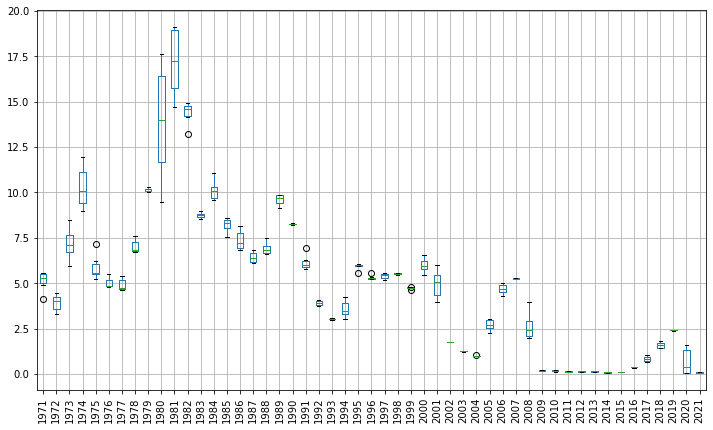

In [15]:
##Shows the value and range of the federal funds interest rate by year
FF_annual.boxplot(figsize = (12,7))
plt.xticks(rotation=90);

## Preprocessing & EDA

Running the Dickey-Fuller Test to check if data is stationary or not. Stationarity means that the statistical properties of a time series (or rather the process generating it) do not change over time. P-value above the .05 threshold at .186, so FEDFUNDs must be transformed to become stationary. P-value is the second value in the output.

In [16]:
dftest = adfuller(df_FF.FEDFUNDS)
print(dftest)

(-2.2563419605644945, 0.18643520648442125, 17, 592, {'1%': -3.441444394224128, '5%': -2.8664345376276454, '10%': -2.569376663737217}, 763.9870224026681)


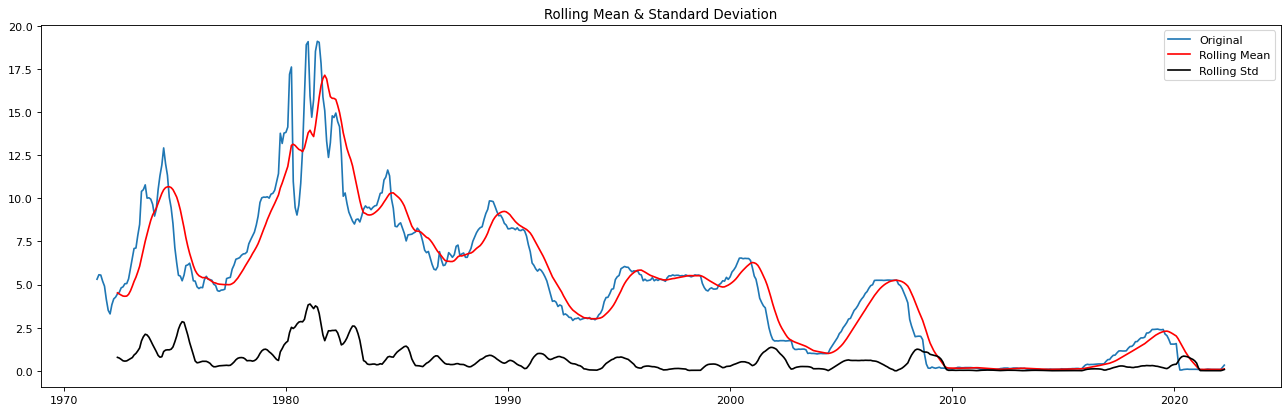

In [17]:
##Visual proof that Fed Funds rate data is non-stationary 
rolmean = df_FF.FEDFUNDS.rolling(window=12).mean()
rolstd = df_FF.FEDFUNDS.rolling(window=12).std()

# Plot rolling statistics:
figure(figsize=(20, 6), dpi=80)
orig = plt.plot(df_FF.FEDFUNDS, label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


Coming back to the stationary definition, what makes our current series non stationary?

A stationary data set is one where the mean, variance, and covariance are not a function of time and remain constant.

Trend - The mean and standard deviation (and therefore variance) for our series is not constant, it varies over time with a large spike at the 300-350 data point (late 70's early 80s). This is a time period of high inflation within the US. 

Cyclically - The values of our series vary over time with an unspecific pattern over time, this is called cyclicality. 

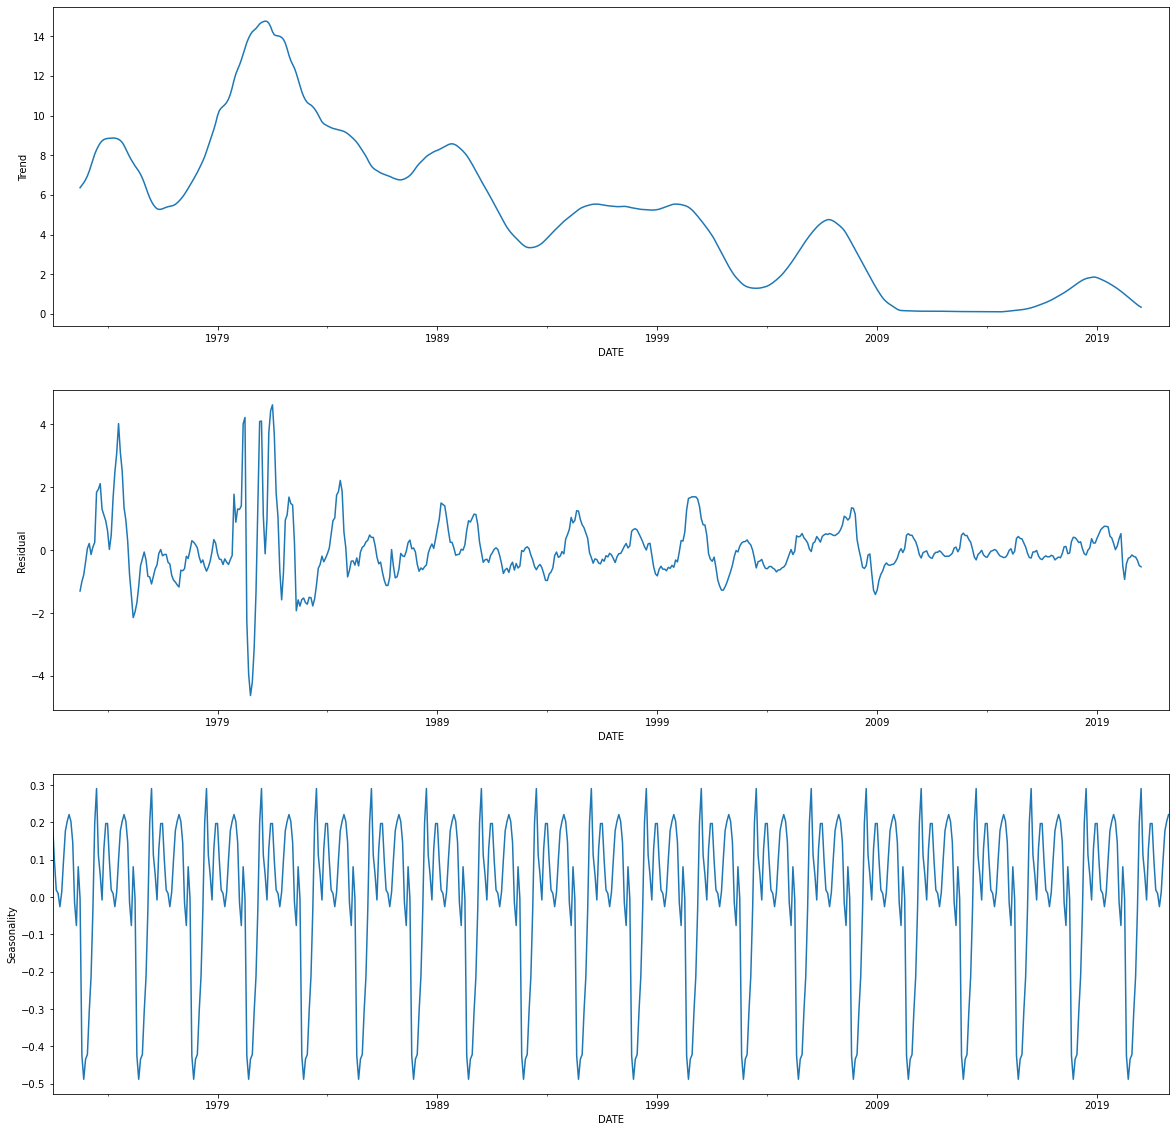

In [22]:
##Seasonal Decomposition 
res = seasonal_decompose(df_FF.FEDFUNDS, model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "Trend")
res.resid.plot(ax=ax2,ylabel = "Residual")
res.seasonal.plot(ax=ax3,ylabel = "Seasonality", figsize=(20,20))
plt.show()

## Autocorrelation Function

* Autocorrelation shows the degree of similarity between a time series and a lagged version of itself over successive time intervals.
* Autocorrelation measures the relationship between a variable’s current value and its past values.
* Does not control for other lags.
* Autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.
* This means that Processes with greater autocorrelation are more predictable than those without any form of autocorrelation. 
* Helps us determine the MA term.

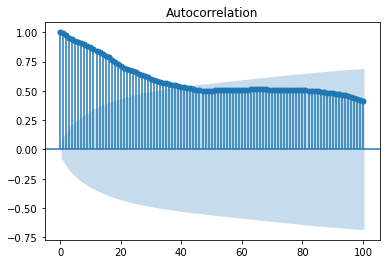

In [18]:
##Using the Autocorrelation Function to check how each time series observation is related to its past
plot_acf(df_FF, lags=100)
plt.show()
###slow gradual decline is another data point showing that we need to difference the dataset

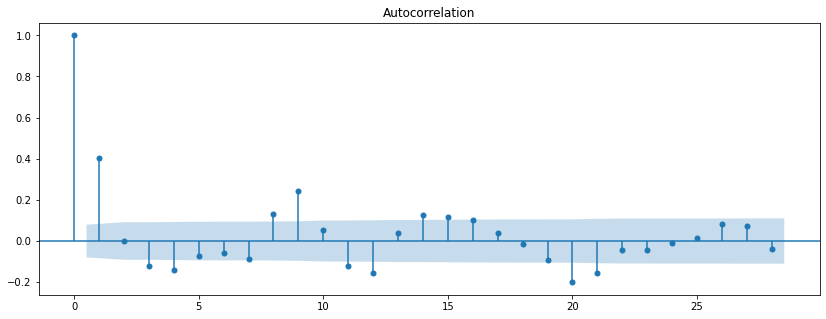

In [24]:
##Using the Autocorrelation Function to check how each time series observation is related to its past
plot_acf(df_FF.diff().dropna())
plt.show()

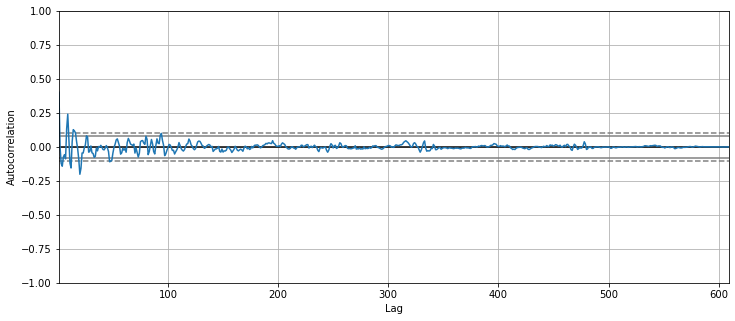

In [20]:
##Using the Autocorrelation Function to check how each time series observation is related to its past, (diff visual)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(df_FF.diff().dropna());

The ACF displays the correlation between our lags and our error. It also helps us determine the starting point of MA term. A lag period of less than 100 months appears to have a higher variance in autocorrelation than longer length lags. Also, the autocorrelation seems to be centered around the value zero, and there appears to be no lag period and its multiple that would be considered statistically significant on a seasonality basis (a lag period that creates a clear trend). Given there are around thirteen statistically significant data points in the ACF (ignoring the point at lag 0), it would likely be preferential to test the MA term from nine to thirteen lags. 

## Partial Autocorrelation Function

* Shows the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. (Controls for other lags)
* If know there is a correlation between our current point and our previous point, we know that we should Auto Regress.
* Helps us determine the AR term. 

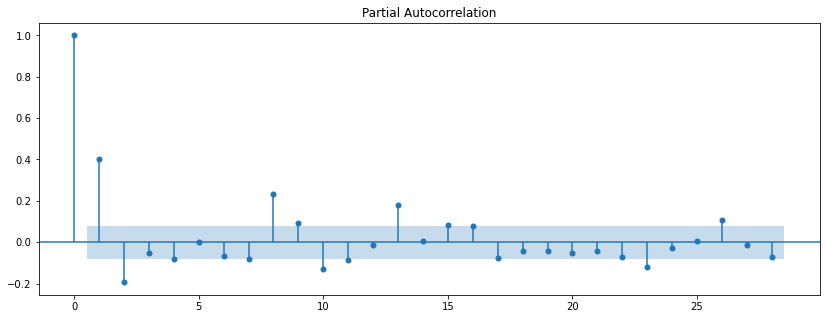

In [21]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(df_FF.diff().dropna());

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed. The Partial Autocorrelation function looks to remove indirect correlations. Given there are between nine and sixteen statistically significant data points in the PACF (ignoring the point at lag 0), it would likely be preferential to test the AR term up to sixteen lags.